In [108]:
!pip install --upgrade --force-reinstall --no-deps albumentations

  Using cached https://files.pythonhosted.org/packages/b0/be/3db3cd8af771988748f69eace42047d5edebf01eaa7e1293f3b3f75f989e/albumentations-1.0.0-py3-none-any.whl
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/KNG_Project/Windows/UNET')

# Copy dataset to drive folder

In [3]:
!cp -r /content/gdrive/MyDrive/KNG_Project/Windows/facial-keypoints-detection/windet_resized.tar.xz /content
!tar -xf /content/windet_resized.tar.xz

^C


In [3]:
from utils import load_checkpoint
from model import UNET
import torch
import torch.nn as nn
import numpy as np
import cv2
import albumentations as A
import torchvision.transforms as T
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from dataset import WindowsDataset
import math

# Train model
Config hyperparameters in train.py

In [37]:
!python /content/gdrive/MyDrive/KNG_Project/Windows/UNET/train.py

[INFO] Epoch:  0
  0% 0/42 [00:00<?, ?it/s]torch.Size([16, 4, 224, 224])
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
torch.Size([16, 4, 224, 224])
torch.Size([16, 4, 224, 224])
  2% 1/42 [00:00<00:21,  1.94it/s, loss=0.506]torch.Size([16, 4, 224, 224])
torch.Size([16, 4, 224, 224])
torch.Size([16, 4, 224, 224])
  5% 2/42 [00:00<00:15,  2.55it/s, loss=0.445]torch.Size([16, 4, 224, 224])
torch.Size([16, 4, 224, 224])
torch.Size([16, 4, 224, 224])
  7% 3/42 [00:00<00:11,  3.25it/s, loss=0.419]torch.Size([16, 4, 224, 224])
torch.Size([16, 4, 224, 224])
torch.Size([16, 4, 224, 224])
 10% 4/42 [00:00<00:09,  4.03it/s, loss=0.399]torch.Siz

# Load pretrained model

In [7]:
model = UNET(in_channels=3, out_channels=4)
load_checkpoint(torch.load('/content/gdrive/MyDrive/KNG_Project/Windows/UNET/my_checkpoint_bk.pth.tar'), model)
model.to('cuda')

=> Loading checkpoint


UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

# Inference model

In [36]:
def predict_image(model, transform, image_path, img_width=224, img_height=224):
    model.eval()
    image = cv2.imread(image_path)
    _image_show = cv2.resize(image, (img_width, img_height))
    plt.imshow(_image_show)
    plt.show()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.0
    image = test_transforms(image=image)["image"]

    with torch.no_grad():
        image = image.to('cuda').float()
        image = torch.unsqueeze(image, 0)
        preds = model(image)
        preds = preds.detach().cpu().numpy()

    index = np.reshape(preds, (1, 4, 1, -1)).argmax(axis=-1)
    index = torch.tensor(index)
    pts = torch.cat([index%img_width, index//img_width], dim=2)
    pts = pts.squeeze(0).numpy()

    res = np.sum(np.transpose(preds[0], [1, 2, 0]), axis=-1)
    plt.imshow(res)
    plt.show()
    model.train()
    return _image_show, pts 

test_transforms = A.Compose([
    A.Resize(height=224, width=224),
    ToTensorV2(),
    ])

In [74]:
KEYPOINT_COLOR = (0, 255, 0) # Green
keypoints = [[3, 2], [208, 2], [207, 210], [4, 211]]

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=3):
    image = image.copy()

    for pt in keypoints:

        cv2.circle(image, (int(pt[0]), int(pt[1])), diameter, (0, 255, 0), -1)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

transform = A.Compose(
    [A.HorizontalFlip(p=1)], 
    keypoint_params=A.KeypointParams(format='xy')
)

transformed = transform(image=img, keypoints=keypoints)
vis_keypoints(transformed['image'], transformed['keypoints'])

NameError: ignored

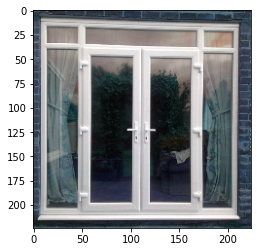

torch.Size([1, 4, 224, 224])


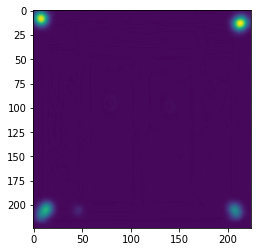

In [76]:
img_path = "/content/gdrive/MyDrive/KNG_Project/Windows/UNET/upvc-french-window-500x500.jpeg"
img, pts = predict_image(model, test_transforms, img_path)
vis_keypoints(img, pts)

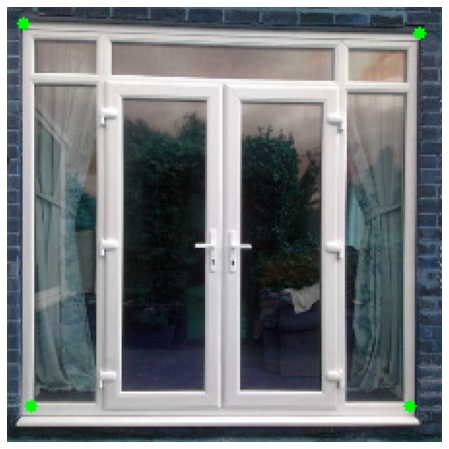

In [77]:
# index = np.reshape(pred, (1, 4, 1, -1)).argmax(axis=-1)
# index = torch.tensor(index)
# pts = torch.cat([index%224, index//224], dim=2)
# pts = pts.squeeze(0).numpy()
# vis_keypoints(img, pts)


### Test gaussian 

In [5]:
### Test dataset
# train_transform = A.Compose(
#         [
#             A.Resize(height=224, width=224),
#             # A.Rotate(limit=35, p=1.0),
#             # A.HorizontalFlip(p=0.5),
#             # A.VerticalFlip(p=0.1),
#             # A.Normalize(
#             #     mean = [0.0, 0.0, 0.0],
#             #     std = [1.0, 1.0, 1.0],
#             #     max_pixel_value = 255.0,
#             # ),
#             ToTensorV2(),
#         ],
#         keypoint_params=A.KeypointParams(format='xy'))

# train_dir = "/content/windows/rs_224/images"
# keypoints_dir = "/content/windows/rs_224/labels"
# train_ds = WindowsDataset(
#     images_dir=train_dir,
#     keypoints_dir=keypoints_dir,
#     transforms=train_transform
# )

# img, target = train_ds[0]
# img = img.numpy()
# img = np.transpose(img, [1, 2, 0])
# target = np.reshape(target, newshape=(224, 224, 4))
# target = np.sum(target, axis=-1)
# plt.imshow(img)
# plt.show()
# plt.imshow(target)

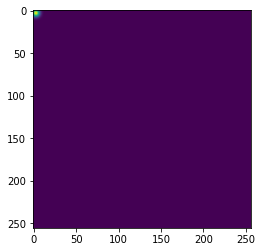

In [71]:
# A gaussian kernel cache, so we don't have to regenerate them every time.
# This is only a small optimization, generating the kernels is pretty fast.
_gaussians = {}

def generate_gaussian(t, x, y, sigma=3):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.
    
    x should be in range (-1, 1) to match the output of fastai's PointScaler.
    
    sigma is the standard deviation of the generated 2D Gaussian.
    """
    h,w = t.shape
    
    # Heatmap pixel per output pixel
    # mu_x = int(0.5 * (x + 1.) * w)
    # mu_y = int(0.5 * (y + 1.) * h)
    mu_x = int(x)
    mu_y = int(y)

    tmp_size = sigma * 3
    
    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)

    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)

    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t
    
    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2
    
    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else np.array((np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2))))
    _gaussians[sigma] = g
    
    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1
    
    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)

    t[img_y_min:img_y_max, img_x_min:img_x_max] = g[g_y_min:g_y_max, g_x_min:g_x_max]
    
    return t

# Example:
hm = generate_gaussian(np.zeros((256, 256)), 3, 3)
plt.imshow(hm)